In [1]:
import networkx as nx
import numpy as np
from numpy.random import choice, rand
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix, find

In [2]:
def infection(m, beta):
    #
    #INPUT:
    # beta = probability of being infected by 1 infected individual
    # m = number of infected neighbors
    #
    #OUTPUT:
    # bool 1 if will be infected, 0 if will not
    #
    inf_probability = 1 - (1-beta)**m
    rand = np.random.rand(1)[0]
    if rand <= inf_probability:
        return 1
    else:
        return 0

In [3]:
def recovery(p):
    #
    #INPUT:
    # p = probability of recover
    #
    #OUTPUT:
    # bool 1 if will recover, 0 if will not
    #
    rand = np.random.rand(1)[0]
    if rand >= p:
        return 1
    else:
        return 0

In [18]:
def epidemic_simulation(G, state, duration, beta, p, vaccination=None):
    #
    #INPUT:
    # G = graph on which I do the simulation
    # state = initial status of individuals (susceptible 0 or infected 1)
    # duration = number of weeks to simulate
    # beta = probability that the infection is spread 1 to 1
    # p = probability of recover
    # vaccination = array that reports the percentage of vaccinated population reached each week
    #
    #OUTPUT:
    # stats: matrix (weeks x number of nodes) that keeps trace of the status of population for each week.
    #        Possible values are: 0 -> susceptible, 1 -> infected, 2 -> recovered, 3 -> vaccinated
    #
    st = np.zeros([duration, state.shape[0]])
    stats = lil_matrix(st,shape=(duration,state.shape[0]),dtype=int)
    stats[0,:] = state
    #vaccination
    if vaccination:
        vaccinated = np.array([])
    for moment in range(1,duration): 
        #vaccination
        if vaccination:
            #choose a percentual of vaccines (accordingly to the array given)
            vaccines = int((vaccination[moment]-vaccination[moment-1])/100 *state.shape[0]) 
            #choose randomly subjects of vaccination
            to_be_vaccinated = choice([x for x in range(state.shape[0]) if x not in vaccinated], vaccines, replace=False) 
            for vac in to_be_vaccinated:
                stats[moment:,vac] = 3 #sets the vaccined state
            vaccinated = np.concatenate([vaccinated,to_be_vaccinated])
        for node in G.nodes:
            #vaccination
            if stats[moment,node] == 3: #vaccinated (skip)
                continue
            node_state = stats[moment-1,node]
            if node_state == 0: #susceptible
                neighbors = [n for n in G.neighbors(node)]
                infected_neighbors = [stats[moment-1,x] for x in neighbors].count(1) #counts the infected neighbors
                stats[moment,node] = infection(infected_neighbors,beta) #check if the subject gets infected
            elif node_state == 1: #infected
                recovered = recovery(p)
                stats[moment,node] = node_state + recovery(p)
                if recovered > 0: #recovered
                    stats[moment:,node] = 2
            else:
                continue
   # stats = csr_matrix(stats) 
    return stats

In [19]:
def multiple_simulation(G, state, duration, beta, p, num, vaccination=None):
    #
    #INPUT:
    # G = graph on which I do the simulation
    # state = initial status of individuals (susceptible 0 or infected 1)
    # duration = number of weeks to simulate
    # beta = probability that the infection is spread 1 to 1
    # p = probability of recover
    # vaccination = array that reports the percentage of vaccinated population reached each week
    # num = number of simulations
    #
    #OUTPUT:
    # stats: matrix (weeks x number of nodes x number of simulations) that keeps trace of the status of population for each week and for each simulation.
    #        Possible values are: 0 -> susceptible, 1 -> infected, 2 -> recovered, 3 -> vaccinated
    #
    
    #initial simulation
    stats = epidemic_simulation(G,state,duration,beta,p,vaccination) 

    for i in range(1,num):
        new_simulation = epidemic_simulation(G,state,duration,beta,p,vaccination)
        stats = np.column_stack((stats, new_simulation)) #update
     
    return stats

In [20]:
#exercise 1.1
N = 500
nodes = range(N)
edges = []
for index,node in enumerate(nodes):
    edges.append([node,nodes[index-1]])
    edges.append([node,nodes[index-2]])
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
status = np.zeros(N)
beta = 0.3
p = 0.7
simulation_time = 15
attempts = 100
#random selection of first 10 affected individuals
init_infected = choice(nodes, 10)
for inf in init_infected:
    status[inf] = 1
print('These are the initially infected individuals (each number corresponds to a specific node):')
print(init_infected)

These are the initially infected individuals (each number corresponds to a specific node):
[368 388 258  55 375 442 310 234 430  55]


In [21]:
#I simulate the epidemic 100 times
res = multiple_simulation(G, status, simulation_time, beta, p, attempts)

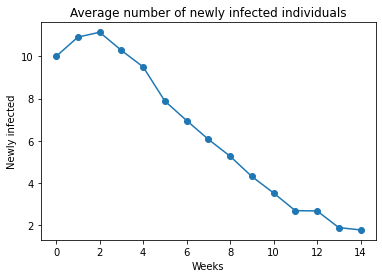

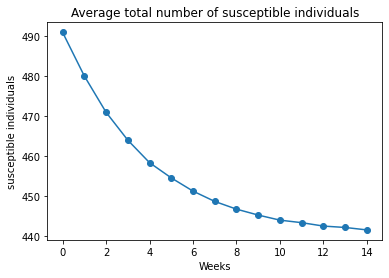

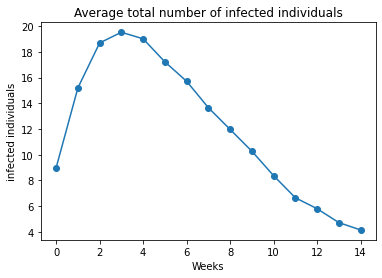

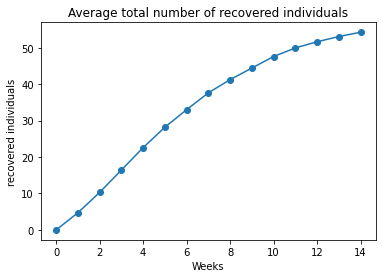

In [22]:
#PLOTS
#newly infected
temp_list_of_lists = []
for simulation in range(0, attempts):
    temp_list = [10]
    for week in range(1, simulation_time):
        counter = 0
        for person in range(0, N):
            if res[0,simulation][week,person] == 1 and res[0,simulation][week-1,person] == 0:
                counter += 1
        temp_list.append(counter)
    temp_list_of_lists.append(temp_list)

avg_increase_evolution = np.mean(np.array(temp_list_of_lists), axis=0)
y_axis = avg_increase_evolution
x_axis = np.arange(simulation_time)
plt.plot(x_axis, y_axis, marker = 'o')
plt.title(f'Average number of newly infected individuals')
plt.xlabel('Weeks')
plt.ylabel('Newly infected')
plt.show()

#total number of susceptible, infected and recovered each week
matrix = []
for category in np.arange(3):
    temp_list_of_lists = []
    for simulation in range(0, attempts):
        temp_list = []
        for week in range(0, simulation_time): 
            counter = 0
            for person in range(0, N):
                if res[0,simulation][week,person] == category:
                    counter += 1
            temp_list.append(counter)
        temp_list_of_lists.append(temp_list)
    matrix.append(temp_list_of_lists)
    
#matrix[0] -> evolution of susceptible people
#matrix[1] -> evolution of infected people
#matrix[2] -> evolution of recovered people

avg_evolution = np.mean(np.array(matrix), axis = 1)

categories = {0 : 'susceptible', 1 : 'infected', 2 : 'recovered'}
for category in np.arange(3):
    y_axis = avg_evolution[category]
    x_axis = np.arange(simulation_time)
    plt.plot(x_axis, y_axis, marker = 'o')
    plt.title(f'Average total number of {categories[category]} individuals')
    plt.xlabel('Weeks')
    plt.ylabel(f'{categories[category]} individuals')
    plt.show()

The degree of the example graph is : 5.0
The degree of the obtained graph is : 20.0


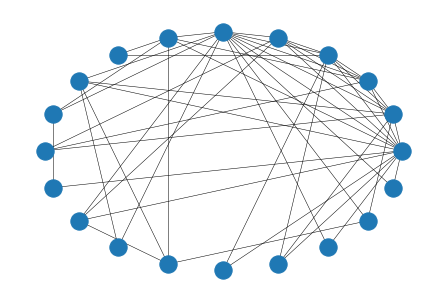

In [23]:
#exercise 1.2
def generate_random_graph(nodes, degree):
    #
    #INPUT:
    # nodes = number of nodes
    # degree = degree of the target graph
    #
    #OUTPUT:
    # G = the obtained graph
    #
    G = nx.complete_graph(degree + 1)
    avg_degree = np.floor(degree / 2)
    if degree % 2 == 0: 
        need_balance = False
    else:
        need_balance = True
    for node in  range(len(G), nodes):
        node = len(G.nodes)
        G.add_node(node)
        grade = avg_degree
        if need_balance == True:
            grade = grade + len(G) % 2
        degrees = np.array([G.degree(x) for x in G.nodes])
        attachment_probabilities = degrees / np.sum(degrees)
        neighbors = np.random.choice(G.nodes, size = int(grade), replace = False, p = attachment_probabilities)
        for neigh in neighbors:
            G.add_edge(node, neigh)
    return G

#example
graph = generate_random_graph(20, 5)
print(f'The degree of the example graph is : {np.mean(np.array([graph.degree(x) for x in graph.nodes]))}')
nx.draw_circular(graph, style = '-', width = 0.5)

#requested by the problem
graph = generate_random_graph(1000, 20)
print(f'The degree of the obtained graph is : {np.mean(np.array([graph.degree(x) for x in graph.nodes]))}')

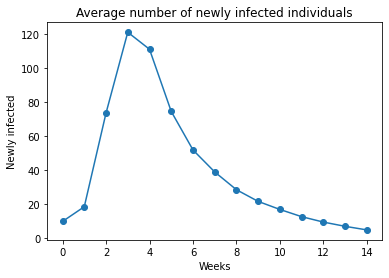

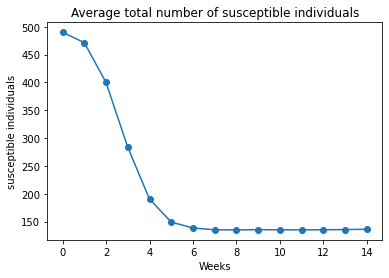

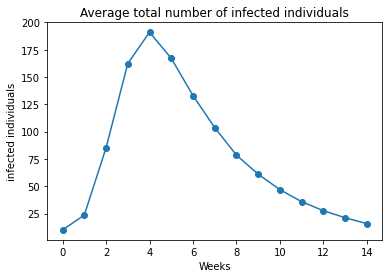

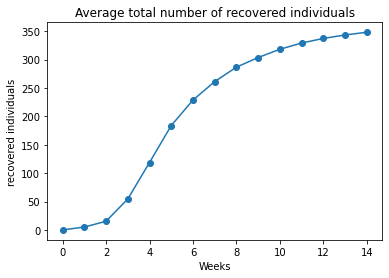

In [24]:
#exercise 2
graph = generate_random_graph(500, 6)
status = np.zeros(500)
beta = 0.3
p = 0.7
simulation_time = 15
attempts = 100
initial_infected = choice(graph.nodes, 10, replace = False)
for inf in initial_infected:
    status[inf] = 1
res = multiple_simulation(graph, state = status, duration = simulation_time, beta = beta, p = p, num = attempts)

#PLOTS
#newly infected
temp_list_of_lists = []
for simulation in range(0, attempts):
    temp_list = [10]
    for week in range(1, simulation_time):
        counter = 0
        for person in range(0, N):
            if res[0,simulation][week,person] == 1 and res[0,simulation][week-1,person] == 0:
                counter += 1
        temp_list.append(counter)
    temp_list_of_lists.append(temp_list)
    
avg_increase_evolution = np.mean(np.array(temp_list_of_lists), axis = 0)
y_axis = avg_increase_evolution
x_axis = np.arange(simulation_time)
plt.plot(x_axis, y_axis, marker = 'o')
plt.title(f'Average number of newly infected individuals')
plt.xlabel('Weeks')
plt.ylabel('Newly infected')
plt.show()

#total number of susceptible, infected and recovered each week
matrix = []
for category in np.arange(3):
    temp_list_of_lists = []
    for simulation in range(0, attempts):
        temp_list = []
        for week in range(0, simulation_time): 
            counter = 0
            for person in range(0, N):
                if res[0,simulation][week,person] == category:
                    counter += 1
            temp_list.append(counter)
        temp_list_of_lists.append(temp_list)
    matrix.append(temp_list_of_lists)
    
#matrix[0] -> evolution of susceptible people
#matrix[1] -> evolution of infected people
#matrix[2] -> evolution of recovered people

avg_evolution = np.mean(np.array(matrix), axis=1)

categories = {0 : 'susceptible', 1 : 'infected', 2 : 'recovered'}
for category in np.arange(3):
    y_axis = avg_evolution[category]
    x_axis = np.arange(simulation_time)
    plt.plot(x_axis, y_axis, marker = 'o')
    plt.title(f'Average total number of {categories[category]} individuals')
    plt.xlabel('Weeks')
    plt.ylabel(f'{categories[category]} individuals')
    plt.show()

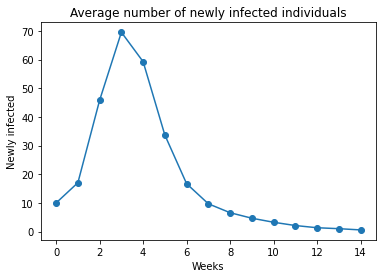

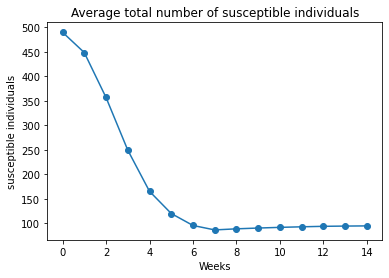

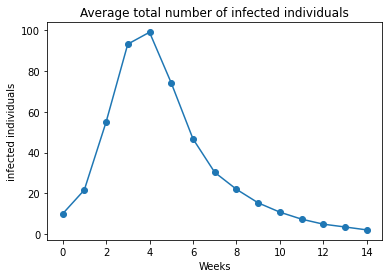

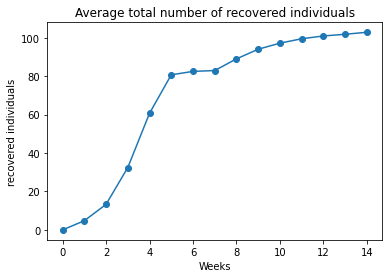

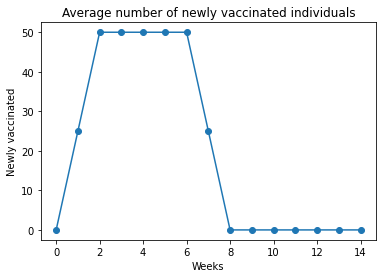

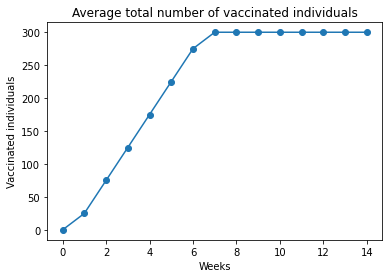

In [25]:
#exercise 3
vacc = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]
N = 500
k = 6
graph = generate_random_graph(N,k)
status = np.zeros(N)
beta = 0.3
p = 0.7
simulation_time = 15
attempts = 100
init_infected = choice(graph.nodes, 10, replace = False)
for inf in init_infected:
    status[inf] = 1
res = multiple_simulation(graph, status, simulation_time, beta, p, attempts, vacc)

#PLOTS
#newly infected
temp_list_of_lists = []
for simulation in range(0, attempts):
    temp_list = [10]
    for week in range(1, simulation_time):
        counter = 0
        for person in range(0, N):
            if res[0,simulation][week,person] == 1 and res[0,simulation][week-1,person] == 0:
                counter += 1
        temp_list.append(counter)
    temp_list_of_lists.append(temp_list)

avg_increase_evolution = np.mean(np.array(temp_list_of_lists), axis = 0)
y_axis = avg_increase_evolution
x_axis = np.arange(simulation_time)
plt.plot(x_axis, y_axis, marker = 'o')
plt.title(f'Average number of newly infected individuals')
plt.xlabel('Weeks')
plt.ylabel('Newly infected')
plt.show()

#total number of susceptible, infected and recovered each week
matrix = []
for category in np.arange(3):
    temp_list_of_lists = []
    for simulation in range(0, attempts):
        temp_list = []
        for week in range(0, simulation_time): 
            counter = 0
            for person in range(0, N):
                if res[0,simulation][week,person] == category:
                    counter += 1
            temp_list.append(counter)
        temp_list_of_lists.append(temp_list)
    matrix.append(temp_list_of_lists)
    
#matrix[0] -> evolution of susceptible people
#matrix[1] -> evolution of infected people
#matrix[2] -> evolution of recovered people

avg_evolution = np.mean(np.array(matrix), axis = 1)

categories = {0 : 'susceptible', 1 : 'infected', 2 : 'recovered'}
for category in np.arange(3):
    y_axis = avg_evolution[category]
    x_axis = np.arange(simulation_time)
    plt.plot(x_axis, y_axis, marker = 'o')
    plt.title(f'Average total number of {categories[category]} individuals')
    plt.xlabel('Weeks')
    plt.ylabel(f'{categories[category]} individuals')
    plt.show()
    
#newly vaccinated
temp_list_of_lists = []
for simulation in range(0, attempts):
    temp_list = [0]
    for week in range(1, simulation_time):
        counter = 0
        for person in range(0, N):
            if res[0,simulation][week,person] == 3 and res[0,simulation][week-1,person] != 3:
                counter += 1
        temp_list.append(counter)
    temp_list_of_lists.append(temp_list)

avg_increase_vaccinated = np.mean(np.array(temp_list_of_lists), axis = 0)
y_axis = avg_increase_vaccinated
x_axis = np.arange(simulation_time)
plt.plot(x_axis, y_axis, marker = 'o')
plt.title(f'Average number of newly vaccinated individuals')
plt.xlabel('Weeks')
plt.ylabel('Newly vaccinated')
plt.show()

#total number of vaccinated
temp_list_of_lists = []
for simulation in range(0, attempts):
    temp_list = []
    for week in range(0, simulation_time): 
        counter = 0
        for person in range(0, N):
            if res[0,simulation][week,person] == 3:
                counter += 1
        temp_list.append(counter)
    temp_list_of_lists.append(temp_list)

avg_evolution_vaccinated = np.mean(np.array(temp_list_of_lists), axis = 0)
y_axis = avg_evolution_vaccinated
x_axis = np.arange(simulation_time)
plt.plot(x_axis, y_axis, marker = 'o')
plt.title('Average total number of vaccinated individuals')
plt.xlabel('Weeks')
plt.ylabel('Vaccinated individuals')
plt.show()

In [28]:
#exercise 4
I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
attempts = 10
simulation_time = 16
weeks = 16

vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
n_nodes = 934
N = 10

status = np.zeros(n_nodes)
initial_infected = choice(range(n_nodes), 1, replace=False)
status[initial_infected]=1

def newly_infected(res, first, simulation_time, N, attempts):
    #INPUT:
    # res = matrix with the status of nodes for each simulation
    # first = newly infected at week 0
    # simulation_time = number of weeks for each simulation
    # N = number of individuals
    # attempts = number of simulations
    #
    #OUTPUT:
    # avg_increase_evolution = array with the average new infected per week 
    #
    temp_list_of_lists = []
    for simulation in range(0, attempts):
        temp_list=[first]
        for week in range(1, simulation_time):
            counter = 0
            for person in range(0, N):
                if res[0,simulation][week,person] == 1 and res[0,simulation][week-1,person] == 0:
                    counter += 1
            temp_list.append(counter)
        temp_list_of_lists.append(temp_list)

    avg_increase_evolution = np.mean(np.array(temp_list_of_lists), axis=0)
    
    return avg_increase_evolution

def searchTop(N, n_nodes, vacc, weeks, I_0, k_start, delta_k, beta_start, delta_beta, ro_start, delta_ro):
    #INPUT:
    # N = number of epidemic simulations
    # n_nodes = number of individuals
    # vacc = vaccinations list
    # weeks = number of weeks for each simulation
    # I_0 = ground truth 
    # k_start = initial k 
    # delta_k = range for k
    # same for both beta and ro
    #
    #OUTPUT:
    # rmse[top] = rmse of the top set of params
    # top = array of indexes associated to the top params 
    # top_k = top value of k
    # top_beta = top value of beta
    # top_ro = top value of ro
    #
    ks = np.array([k_start - delta_k, k_start, k_start + delta_k])
    betas = np.array([beta_start - delta_beta, beta_start, beta_start + delta_beta])
    ros = np.array([ro_start - delta_ro, ro_start, ro_start + delta_ro])
    
    #check the three arrays have acceptable elements (betas[i] and ros[i] in [0,1]; ks[i] >= 2)
    for i in range(3):
        
        if betas[i] < 0.0:
            betas[i] = 0.0
        elif betas[i] > 1.0:
            betas[i] = 1.0
        
        if ros[i] < 0.0:
            ros[i] = 0.0
        elif ros[i] > 1.0:
            ros[i] = 1
        
        if ks[i] < 2:
            ks[i] = 2
    
    #rmse initialization
    rmse = np.zeros((3, 3, 3))
    
    for i,k in enumerate(ks):
        for c,b in enumerate(betas):
            for ct,r in enumerate(ros):
                #1a) generate a random graph
                RG = generate_random_graph(n_nodes, k)
                #1b) epidemic simulation
                res = multiple_simulation(RG, status, weeks, b, r, N, vacc)
                new_I_nodes_avg = newly_infected(res, first=1, simulation_time=weeks, N=n_nodes, attempts=N)
                
                #1c)rmse computation
                rmse[i,c,ct] = np.sqrt((1 / (weeks - 1)) * np.sum((new_I_nodes_avg - I_0) ** 2))
                
    #2) find parameters associated with minimum rmse
    top = np.unravel_index(np.argmin(rmse),shape=(3,3,3)) 
    top_k = ks[top[0]]
    top_beta = betas[top[1]]
    top_ro = ros[top[2]]
    
    return rmse[top], top, top_k, top_beta, top_ro
    
def findParams(N, n_nodes, vacc, weeks, I_0, k_start, delta_k, beta_start, delta_beta, ro_start, delta_ro):
    #INPUT:
    # inputs for searchTop function
    #
    #OUTPUT:
    # output is the same of searchTop function
    # 
    
    #flag to decide when to end 
    top_continue = True
    #to keep best parameters
    top_res = None 
    
    while top_continue:
        
        params = searchTop(N, n_nodes, vacc, weeks, I_0, k_start, delta_k, beta_start, delta_beta, ro_start, delta_ro)
        rmse = params[0]
        top_combination = params[1]
        top_k = params[2]
        top_beta = params[3]
        top_ro = params[4]
        
        print(f"RMSE_error : {rmse}")
        print(f"K : {top_k}")
        print(f"beta : {top_beta}")
        print(f"ro : {top_ro}")
        
        #understand if there is an improvement or not (all different cases are managed)
        if top_res == None:
            top_res = params
        
        if (k_start,beta_start,ro_start) == (top_k,top_beta,top_ro):
            top_continue = False
            
            if(params[0] < top_res[0]):
                top_res = params
                
        elif (params[0] > top_res[0]):
            top_continue = False
        
        else:
            top_res = params
            k_start, beta_start, ro_start = (top_k, top_beta, top_ro)
    
    return top_res

In [29]:
#as written in the hint, I play around with deltas
delta_ks = [2, 2, 1, 1]
delta_betas = [0.2, 0.1, 0.05, 0.025]
delta_ros = [0.3, 0.2, 0.1, 0.05]

k_start = 10
beta_start = 0.3
ro_start = 0.6

top_res = None

for i in range (4):
    delta_k = delta_ks[i]
    delta_beta = delta_betas[i]
    delta_ro = delta_ros[i]
    
    params = findParams(N, n_nodes, vacc, weeks, I_0, k_start, delta_k, beta_start, delta_beta, ro_start, delta_ro)
    
    rmse = params[0]
    top_combination = params[1]
    top_k = params[2]
    top_beta = params[3]
    top_ro = params[4]
    
    if top_res is None or top_res[0] > rmse:
        top_res = params
        
rmse = top_res[0]
top_combination = top_res[1]
top_k = top_res[2]
top_beta = top_res[3]
top_ro = top_res[4]

print(top_res)

RMSE_error : 8.91036849219305
K : 12
beta : 0.09999999999999998
ro : 0.3
RMSE_error : 7.644605941446557
K : 10
beta : 0.09999999999999998
ro : 0.6
RMSE_error : 10.856395964284525
K : 12
beta : 0.09999999999999998
ro : 0.3
RMSE_error : 5.437769150426793
K : 8
beta : 0.19999999999999998
ro : 0.39999999999999997
RMSE_error : 3.763243282064023
K : 6
beta : 0.3
ro : 0.19999999999999996
RMSE_error : 4.701347324615218
K : 8
beta : 0.19999999999999998
ro : 0.39999999999999997
RMSE_error : 10.691024272725228
K : 9
beta : 0.25
ro : 0.5
RMSE_error : 6.101092798288954
K : 10
beta : 0.2
ro : 0.4
RMSE_error : 4.799513864271394
K : 11
beta : 0.15000000000000002
ro : 0.4
RMSE_error : 2.8386616564853235
K : 12
beta : 0.15000000000000002
ro : 0.4
RMSE_error : 4.229420764123616
K : 11
beta : 0.2
ro : 0.30000000000000004
RMSE_error : 21.600879611719517
K : 9
beta : 0.27499999999999997
ro : 0.5499999999999999
RMSE_error : 6.06943160435967
K : 8
beta : 0.24999999999999997
ro : 0.49999999999999994
RMSE_error

In [32]:
#run multiple_simulation with the best parameters
#I repeat initializations
I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
attempts = 10
simulation_time = 16
weeks = 16
vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
N = 934
status = np.zeros(N)
initial_infected = choice(range(N), 1, replace = False)
status[initial_infected]=1
RG = generate_random_graph(N, top_k)

#run simulation
res = multiple_simulation(RG, status, weeks, top_beta, top_ro, attempts, vacc)

[Text(0.5, 0, 'Weeks'),
 Text(0, 0.5, 'Newly infected'),
 Text(0.5, 1.0, 'Average number of newly infected individuals')]

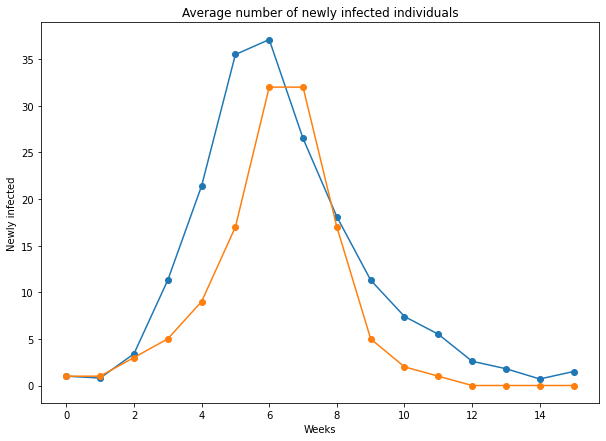

In [35]:
#PLOTS
#newly infected
temp_list_of_lists = []
for simulation in range(0, attempts):
    temp_list = [1]
    for week in range(1, simulation_time):
        counter = 0
        for person in range(0, N):
            if res[0,simulation][week,person] == 1 and res[0,simulation][week-1,person] == 0:
                counter += 1
        temp_list.append(counter)
    temp_list_of_lists.append(temp_list)

avg_increase_evolution = np.mean(np.array(temp_list_of_lists), axis = 0)
y_axis = avg_increase_evolution
x_axis = np.arange(simulation_time)

ig, ax = plt.subplots(figsize = (10,7))
ax.plot(x_axis, y_axis, label = 'Newly infected (Simulation)', marker = 'o')
ax.plot(x_axis, I_0, label = 'Newly infected (GT)', marker = 'o')
ax.set(xlabel = 'Weeks', ylabel = 'Newly infected', title = 'Average number of newly infected individuals')

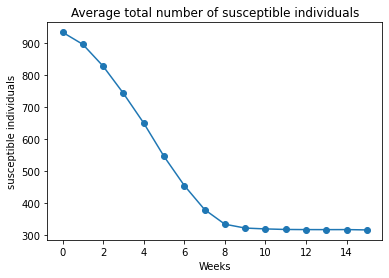

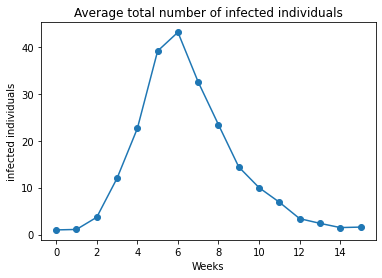

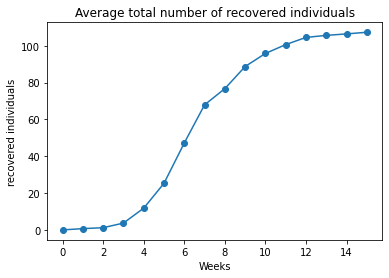

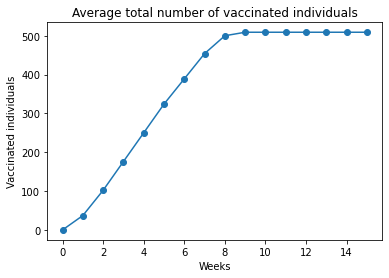

In [37]:
#total number of susceptible, infected and recovered each week
matrix = []
for category in np.arange(3):
    temp_list_of_lists = []
    for simulation in range(0, attempts):
        temp_list = []
        for week in range(0, simulation_time): 
            counter = 0
            for person in range(0, N):
                if res[0,simulation][week,person] == category:
                    counter += 1
            temp_list.append(counter)
        temp_list_of_lists.append(temp_list)
    matrix.append(temp_list_of_lists)


avg_evolution = np.mean(np.array(matrix), axis = 1)

categories = {0 : 'susceptible', 1 : 'infected', 2 : 'recovered'}
for category in np.arange(3):
    y_axis = avg_evolution[category]
    x_axis = np.arange(simulation_time)
    plt.plot(x_axis, y_axis, marker = 'o')
    plt.title(f'Average total number of {categories[category]} individuals')
    plt.xlabel('Weeks')
    plt.ylabel(f'{categories[category]} individuals')
    plt.show()
    

#total number of vaccinated
temp_list_of_lists = []
for simulation in range(0, attempts):
    temp_list = []
    for week in range(0, simulation_time): 
        counter = 0
        for person in range(0, N):
            if res[0,simulation][week,person] == 3:
                counter += 1
        temp_list.append(counter)
    temp_list_of_lists.append(temp_list)

avg_evolution_vaccinated = np.mean(np.array(temp_list_of_lists), axis = 0)
y_axis = avg_evolution_vaccinated
x_axis = np.arange(simulation_time)
plt.plot(x_axis, y_axis, marker = 'o')
plt.title('Average total number of vaccinated individuals')
plt.xlabel('Weeks')
plt.ylabel('Vaccinated individuals')
plt.show()